In [2]:
import uavgeo as ug
import geopandas as gpd
import rioxarray
import numpy as np
import ultralytics
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from rasterstats import zonal_stats

# VIGOR Mapping of vineyards (based on Matese et al.)

Somewhat similar to DEM creation implementation wise, but with different extraction methods and input data

1. Load data
2. Filter the NDVI for canopies
3. 2mx2m extraction grid
4. median extract filtered NDVI
5. classify vigor
6. evaluate classifications

## BTG2022 vigor mapping

In [2]:
# LOAD DATA bt2022

ndvi_p2phd = rxr.open_rasterio("../data/orthos/reconstructed/ndvi_p2p_hd_2022.tif",mode = "w")
ndvi_p2p = rxr.open_rasterio("../data/orthos/reconstructed/ndvi_p2p_v2_2022.tif",mode = "w")
ndvi_test = rxr.open_rasterio("../data/orthos/ndvi_2022_test.tif",mode = "w")
rgb = rxr.open_rasterio("../data/orthos/rgb_2022.tif",mode = "w")

chm = rxr.open_rasterio("../data/orthos/rgb_2022_chm.tif",mode = "w")



In [3]:
# align reproject etc.
#pixel-level alignment of the dem,dsm,chm rasters:

chm = chm.rio.reproject_match(ndvi_test)
rgb = rgb.rio.reproject_match(ndvi_test)
ndvi_p2p = ndvi_p2p.rio.reproject_match(ndvi_test)
ndvi_p2phd = ndvi_p2phd.rio.reproject_match(ndvi_test)

In [4]:

roi = gpd.read_file("../data/bbr/btg2022/roi/RoI.shp")
#clip all to the same extent
ndvi_test = ndvi_test.rio.clip(roi.geometry)
ndvi_p2phd = ndvi_p2phd.rio.clip(roi.geometry)
ndvi_p2p = ndvi_p2p.rio.clip(roi.geometry)
chm = chm.rio.clip(roi.geometry)
rgb = rgb.rio.clip(roi.geometry)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [5]:
#cset nodata value
ndvi_test = ndvi_test.rio.write_nodata(ndvi_test.rio.nodata, encoded=True)
ndvi_p2phd = ndvi_p2phd.rio.write_nodata(ndvi_p2phd.rio.nodata, encoded=True)
ndvi_p2p = ndvi_p2p.rio.write_nodata(ndvi_p2p.rio.nodata, encoded=True)
chm = chm.rio.write_nodata(chm.rio.nodata, encoded=True)
rgb = rgb.rio.write_nodata(rgb.rio.nodata, encoded=True)

In [54]:
# add rgbvi into the mix
rgbvi = xr.full_like(ndvi_test, fill_value = np.nan)
vals = ug.compute.calc_rgbvi(rgb, red_id = 1, green_id = 2, blue_id= 3, rescale = False).values
rgbvi.values = vals.reshape(rgbvi.values.shape)

In [56]:
# Filter canopies based on 0.5m height: as usual
#select plants only
vines_mask = ((chm >= 0.5) & (chm <= 2))
vines_chm = chm.where( vines_mask)
vines_chm = vines_chm.rio.write_nodata(vines_chm.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_test = ndvi_test.where(vines_mask)
vines_ndvi_test_mask = vines_ndvi_test<1
vines_ndvi_test = vines_ndvi_test.where(vines_ndvi_test_mask)
vines_ndvi_test = vines_ndvi_test.rio.write_nodata(vines_ndvi_test.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2p = ndvi_p2p.where(vines_mask)
vines_ndvi_p2p_mask = vines_ndvi_p2p<1
vines_ndvi_p2p = vines_ndvi_p2p.where(vines_ndvi_p2p_mask)
vines_ndvi_p2p = vines_ndvi_p2p.rio.write_nodata(vines_ndvi_p2p.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2phd = ndvi_p2phd.where(vines_mask)
vines_ndvi_p2phd_mask = vines_ndvi_p2phd<1
vines_ndvi_p2phd = vines_ndvi_p2phd.where(vines_ndvi_p2phd_mask)
vines_ndvi_p2phd= vines_ndvi_p2phd.rio.write_nodata(vines_ndvi_p2phd.rio.nodata, encoded = True)

# only extract NDVI from thwere there are vine plants
vines_ndvi_rgbvi = rgbvi.where(vines_mask)
vines_ndvi_rgbvi_mask = vines_ndvi_rgbvi<1
vines_ndvi_rgbvi = vines_ndvi_rgbvi.where(vines_ndvi_rgbvi_mask)
vines_ndvi_rgbvi= vines_ndvi_rgbvi.rio.write_nodata(vines_ndvi_rgbvi.rio.nodata, encoded = True)

In [58]:
t = gpd.read_file("../data/bbr/btg2022/plants.geojson")

In [59]:
real = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_test, prefix = "ndvi_")
fake= ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2p, prefix= "ndvi_")
fakeHD= ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2phd, prefix = "ndvi_")
vi = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_rgbvi, prefix = "ndvi_")

In [60]:
# rejoin the geometries from the grid dataset
real= t.merge(real, on = "plantID")
fake= t.merge(fake, on = "plantID",)
fakeHD = t.merge(fakeHD, on = "plantID")
vi = t.merge(vi, on = "plantID")

In [74]:
def vigor_mapping(ndvi, sampling_meters, roi=None):
    # Create 2mx2m grid with UG
    pixel_size = ndvi.rio.resolution()[0]
    
    
    xy_dims = int(sampling_meters/pixel_size)
    
    input_dims = {"x": xy_dims, "y":xy_dims}
    input_overlap = {"x": 0, "y":0}
    
    #shape (resolution) of input image
    shape = ndvi.shape
    c = ndvi.rio.crs
    chips = ug.compute.create_chip_bounds_gdf(input_dims = input_dims, input_overlap=input_overlap, shape_x = shape[2], shape_y = shape[1], crs = c)
    chips["crs_geom"] = chips["geometry"].apply(lambda x: ug.compute.imgref_to_crs(ndvi, x)) 
    chips = chips.set_geometry(chips["crs_geom"])

    # extract mean values with bboxes (and filtered NDVI)
    if roi is not None:
        chips["intersects"] = chips["geometry"].apply(lambda x: roi.intersects(x))
        chips = chips[chips["intersects"]].copy()
    
    chips["ndvi_mean"] = chips.apply(lambda x: np.nanmean(ndvi.rio.clip_box(minx = x.geometry.bounds[0], 
                                   miny =x.geometry.bounds[1] ,
                                   maxx =x.geometry.bounds[2] , 
                                   maxy= x.geometry.bounds[3]),), axis=1)
    return chips

In [75]:
ndvi_test_vigor = vigor_mapping(vines_ndvi_test, 2,roi=roi)
ndvi_p2p_vigor = vigor_mapping(vines_ndvi_p2p, 2, roi=roi)
ndvi_p2phd_vigor = vigor_mapping(vines_ndvi_p2phd, 2, roi=roi)

C:\Users\judoj\AppData\Local\Temp\ipykernel_22900\1093472373.py:27: RuntimeWarning: Mean of empty slice
  chips["ndvi_mean"] = chips.apply(lambda x: np.nanmean(ndvi.rio.clip_box(minx = x.geometry.bounds[0],
C:\Users\judoj\AppData\Local\Temp\ipykernel_22900\1093472373.py:27: RuntimeWarning: Mean of empty slice
  chips["ndvi_mean"] = chips.apply(lambda x: np.nanmean(ndvi.rio.clip_box(minx = x.geometry.bounds[0],
C:\Users\judoj\AppData\Local\Temp\ipykernel_22900\1093472373.py:27: RuntimeWarning: Mean of empty slice
  chips["ndvi_mean"] = chips.apply(lambda x: np.nanmean(ndvi.rio.clip_box(minx = x.geometry.bounds[0],


In [ ]:
ndvi_test_vigor = ug.compute.tertiler(real)
ndvi_p2p_vigor = ug.compute.tertiler(fake)
ndvi_p2phd_vigor = ug.compute.tertiler(fakeHD)
rgbvi_vigor = ug.compute.tertiler(vi)

In [63]:
#reduce RGB size for plotting
rgb = rxr.open_rasterio("../data/orthos/rgb_2022.tif",mode = "w")

from rasterio.enums import Resampling

upscale_factor =0.1
new_width = rgb.rio.width * upscale_factor
new_height = rgb.rio.height * upscale_factor


rgb_down =rgb.rio.reproject(
   rgb.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)


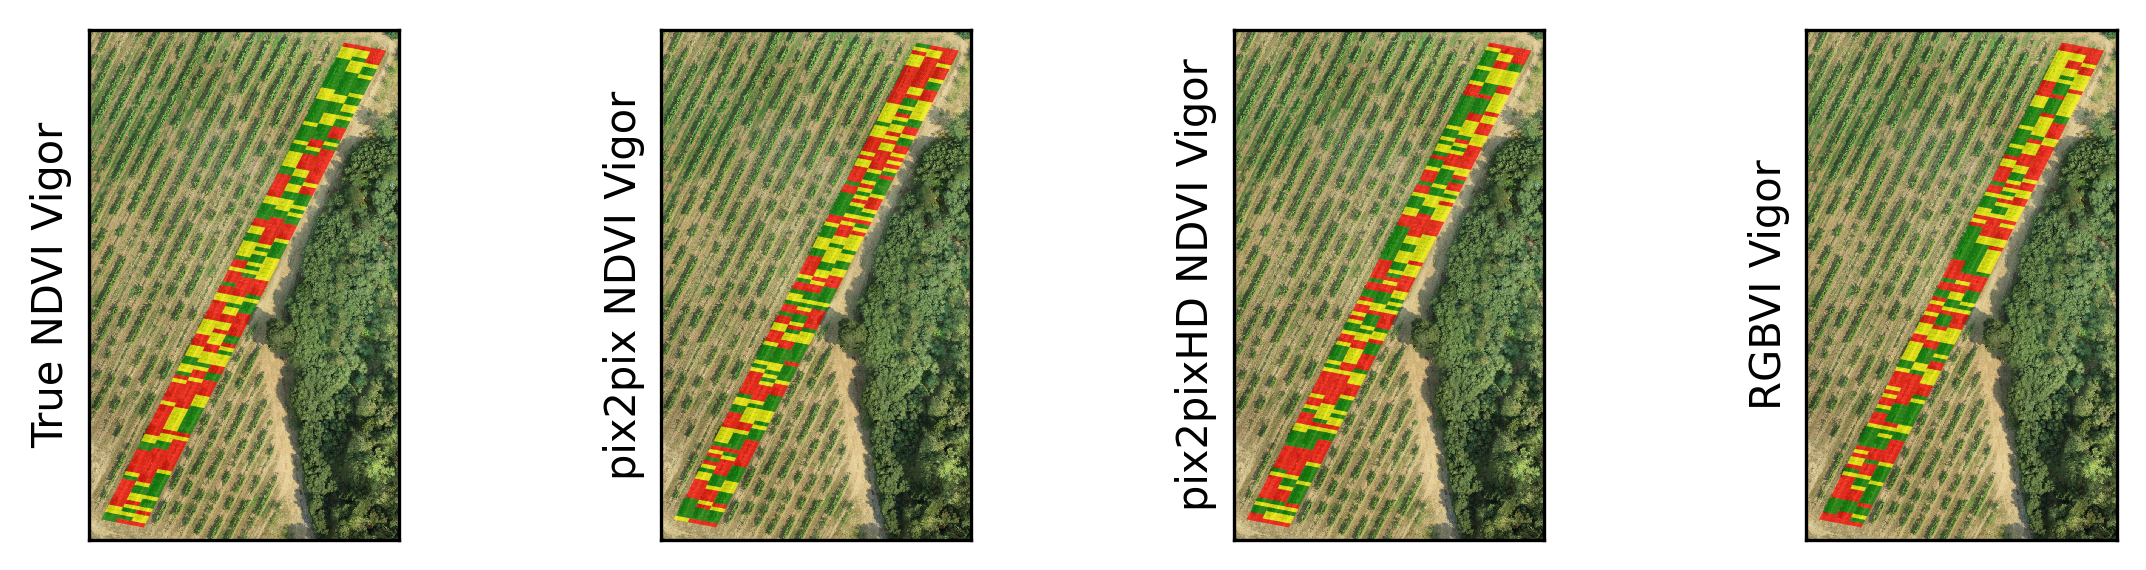

In [64]:
# plot thes 2x2 grid
d = {"low":"red", "medium":"yellow", "high":"green"}
ndvi_test_vigor["colour"] = ndvi_test_vigor["vigor_class"].map(d)
ndvi_p2p_vigor["colour"] = ndvi_p2p_vigor["vigor_class"].map(d)
ndvi_p2phd_vigor["colour"] = ndvi_p2phd_vigor["vigor_class"].map(d)
rgbvi_vigor["colour"] = rgbvi_vigor["vigor_class"].map(d)

fig,ax = plt.subplots(figsize=(8,2),nrows =1, ncols = 4,dpi=300)

bounds = ndvi_test_vigor.total_bounds
off= 3
rgb_down.plot.imshow(ax=ax[0],add_colorbar=False)
ndvi_test_vigor.plot(ax=ax[0], color=ndvi_test_vigor["colour"] , alpha=0.7)
ax[0].set_xlim()
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI Vigor")
ax[0].set_xlim(bounds[0]-off,bounds[2]+off)
ax[0].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[1],add_colorbar=False)
ndvi_p2p_vigor.plot(ax=ax[1], color=ndvi_p2p_vigor["colour"] , alpha=0.7)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix NDVI Vigor")
ax[1].set_xlim(bounds[0]-off,bounds[2]+off)
ax[1].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[2],add_colorbar=False)
ndvi_p2phd_vigor.plot(ax=ax[2], color=ndvi_p2phd_vigor["colour"], alpha=0.7 )
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD NDVI Vigor")
ax[2].set_xlim(bounds[0]-off,bounds[2]+off)
ax[2].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[3],add_colorbar=False)
rgbvi_vigor.plot(ax=ax[3], color=rgbvi_vigor["colour"], alpha=0.7 )
ax[3].set_title("")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("RGBVI Vigor")
ax[3].set_xlim(bounds[0]-off,bounds[2]+off)
ax[3].set_ylim(bounds[1]-off,bounds[3]+off)

plt.tight_layout()
plt.savefig("figures/btg2022_vigor_map.png")
plt.show()

In [65]:
# Accuracy matrix, F1 score, of low-medium-high 
test_p2p = pd.merge(left = ndvi_test_vigor, right= ndvi_p2p_vigor, on="plantID")[["plantID", "geometry_x", "vigor_class_x", "vigor_class_y"]]
test_p2phd = pd.merge(left = ndvi_test_vigor, right= ndvi_p2phd_vigor, on="plantID")[["plantID", "geometry_x", "vigor_class_x", "vigor_class_y"]]
test_rgbvi = pd.merge(left = ndvi_test_vigor, right= rgbvi_vigor, on="plantID")[["plantID", "geometry_x", "vigor_class_x", "vigor_class_y"]]

test_p2p = test_p2p.dropna(axis=0)
test_p2phd = test_p2phd.dropna(axis=0)
test_rgbvi = test_rgbvi.dropna(axis=0)

from sklearn.metrics import confusion_matrix, f1_score
clses = ["low", "medium", "high"]
conf_p2p = confusion_matrix(test_p2p["vigor_class_x"], test_p2p["vigor_class_y"], labels = clses)

conf_p2phd = confusion_matrix(test_p2phd["vigor_class_x"], test_p2phd["vigor_class_y"], labels = clses)

conf_rgbvi = confusion_matrix(test_rgbvi["vigor_class_x"], test_rgbvi["vigor_class_y"], labels = clses)


f1_p2p = f1_score(test_p2p["vigor_class_x"], test_p2p["vigor_class_y"], average='weighted')

f1_p2phd = f1_score(test_p2phd["vigor_class_x"], test_p2phd["vigor_class_y"], average='weighted')

f1_rgbvi =  f1_score(test_rgbvi["vigor_class_x"], test_rgbvi["vigor_class_y"], average='weighted')

In [66]:
print( "btg2022 f1 score p2p: ", "{:.3f}".format(f1_p2p), "matrix:")
print(pd.DataFrame(conf_p2p))
print( "btg2022 f1 score p2phd: ", "{:.3f}".format(f1_p2phd), "matrix:")
print(pd.DataFrame(conf_p2phd))

print( "btg2022 f1 score rgbvi: ", "{:.3f}".format(f1_rgbvi), "matrix:")
print(pd.DataFrame(conf_rgbvi))


btg2022 f1 score p2p:  0.419 matrix:
    0   1   2
0  81  27  38
1  30  44  45
2  35  48  36
btg2022 f1 score p2phd:  0.492 matrix:
    0   1   2
0  98  27  21
1  26  43  50
2  22  49  48
btg2022 f1 score rgbvi:  0.487 matrix:
    0   1   2
0  95  28  23
1  27  44  48
2  24  47  48


## Canyelles Vigor Mapping 

This will take a while to run :)


In [ ]:
ndvi_test = rxr.open_rasterio("../data/canyelles/orthos/preprocessed/ndvi_test.tif")
ndvi_p2p = rxr.open_rasterio("../data/canyelles/orthos/preprocessed/ndvi_p2p.tif")
ndvi_p2phd = rxr.open_rasterio("../data/canyelles/orthos/preprocessed/ndvi_p2phd.tif")
chm= rxr.open_rasterio("../data/canyelles/orthos/preprocessed/chm.tif")
rgbvi = rxr.open_rasterio("../data/canyelles/orthos/preprocessed/rgbvi.tif")


In [57]:
#select plants only
vines_mask = ((chm >= 0.5) & (chm <= 2))
vines_chm = chm.where( vines_mask)
vines_chm = vines_chm.rio.write_nodata(vines_chm.rio.nodata, encoded = True)

In [58]:
# only extract NDVI from thwere there are vine plants
vines_ndvi_test = ndvi_test.where(vines_mask)
vines_ndvi_test_mask = vines_ndvi_test<1
vines_ndvi_test = vines_ndvi_test.where(vines_ndvi_test_mask)
vines_ndvi_test = vines_ndvi_test.rio.write_nodata(vines_ndvi_test.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2p = ndvi_p2p.where(vines_mask)
vines_ndvi_p2p_mask = vines_ndvi_p2p<1
vines_ndvi_p2p = vines_ndvi_p2p.where(vines_ndvi_p2p_mask)
vines_ndvi_p2p = vines_ndvi_p2p.rio.write_nodata(vines_ndvi_p2p.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2phd = ndvi_p2phd.where(vines_mask)
vines_ndvi_p2phd_mask = vines_ndvi_p2phd<1
vines_ndvi_p2phd = vines_ndvi_p2phd.where(vines_ndvi_p2phd_mask)
vines_ndvi_p2phd= vines_ndvi_p2phd.rio.write_nodata(vines_ndvi_p2phd.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_rgbvi = rgbvi.where(vines_mask)
vines_ndvi_rgbvi_mask = vines_ndvi_rgbvi<1
vines_ndvi_rgbvi = vines_ndvi_rgbvi.where(vines_ndvi_rgbvi_mask)
#vines_ndvi_rgbvi= vines_ndvi_rgbvi.rio.write_nodata(vines_ndvi_rgbvi.rio.nodata, encoded = True)

In [59]:
t = gpd.read_file("../data/bbr/can2023/plants.geojson")

In [60]:
real = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_test, prefix = "ndvi_")
fake= ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2p, prefix= "ndvi_")
fakeHD= ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2phd, prefix = "ndvi_")
vi = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_rgbvi, prefix = "ndvi_")

In [62]:
# rejoin the geometries from the grid dataset
real= t.merge(real, on = "id")
fake= t.merge(fake, on = "id",)
fakeHD = t.merge(fakeHD, on = "id")
vi = t.merge(vi, on = "id")


In [64]:
def tertiler(df,min=-1,max=10000):
    
    # Get tertile positions
    tertiles = df['ndvi_mean'].quantile([1/3,2/3]).tolist()
    # Add a lower and upper range for the bins in pd.cut
    tertiles = [min] + tertiles + [max]
    print(tertiles)
    # Add a new tertile column to the data frame based on the tertile cut
    df['vigor_class'] = pd.cut(df['ndvi_mean'].fillna(0), bins=tertiles, labels=['low', 'medium', 'high'])
    
    return df

In [65]:
ndvi_test_vigor = tertiler(real)
ndvi_p2p_vigor = tertiler(fake)
ndvi_p2phd_vigor = tertiler(fakeHD)
rgbvi_vigor = tertiler(vi)

[-1, 0.6139701228446731, 0.6691999749326605, 10000]
[-1, 0.7734125172404985, 0.826878703447927, 10000]
[-1, 0.5891827391788026, 0.6231866373552443, 10000]
[-1, 0.42601289366426087, 0.49466270318718636, 10000]


In [66]:
#reduce RGB size for plotting
rgb = rxr.open_rasterio("../data/canyelles/orthos/rgb_230609.tif", chunks=True)
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = rgb.rio.width * upscale_factor
new_height = rgb.rio.height * upscale_factor


rgb_down =rgb.rio.reproject(
   "EPSG:32631",
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)


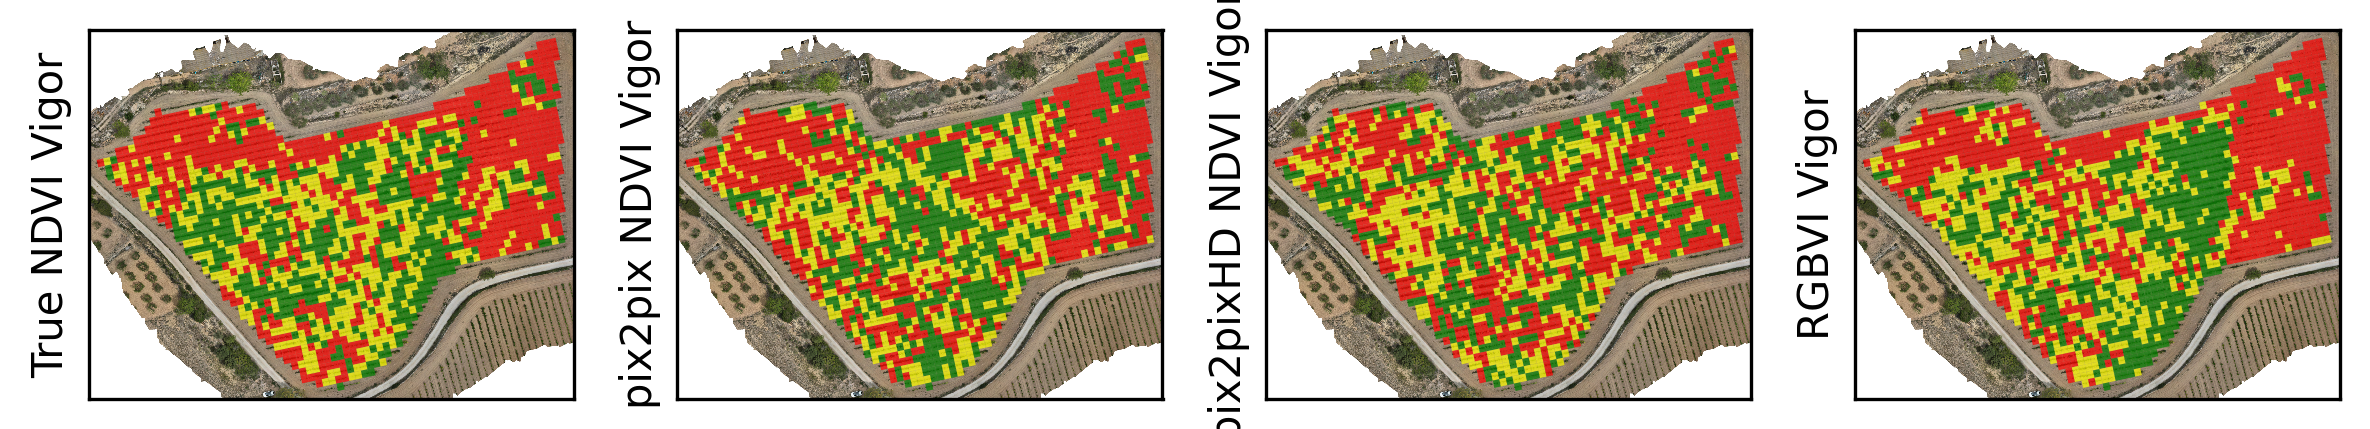

In [67]:
# plot thes 2x2 grid
d = {"low":"red", "medium":"yellow", "high":"green"}
ndvi_test_vigor["colour"] = ndvi_test_vigor["vigor_class"].map(d)
ndvi_p2p_vigor["colour"] = ndvi_p2p_vigor["vigor_class"].map(d)
ndvi_p2phd_vigor["colour"] = ndvi_p2phd_vigor["vigor_class"].map(d)
rgbvi_vigor["colour"] = rgbvi_vigor["vigor_class"].map(d)

fig,ax = plt.subplots(figsize=(8,2),nrows =1, ncols = 4,dpi=300)

bounds = ndvi_test_vigor.total_bounds
off= 3
rgb_down.plot.imshow(ax=ax[0],add_colorbar=False)
ndvi_test_vigor.plot(ax=ax[0], color=ndvi_test_vigor["colour"] , alpha=0.7)
ax[0].set_xlim()
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI Vigor")
ax[0].set_xlim(bounds[0]-off,bounds[2]+off)
ax[0].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[1],add_colorbar=False)
ndvi_p2p_vigor.plot(ax=ax[1], color=ndvi_p2p_vigor["colour"] , alpha=0.7)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix NDVI Vigor")
ax[1].set_xlim(bounds[0]-off,bounds[2]+off)
ax[1].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[2],add_colorbar=False)
ndvi_p2phd_vigor.plot(ax=ax[2], color=ndvi_p2phd_vigor["colour"], alpha=0.7 )
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD NDVI Vigor")
ax[2].set_xlim(bounds[0]-off,bounds[2]+off)
ax[2].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[3],add_colorbar=False)
rgbvi_vigor.plot(ax=ax[3], color=rgbvi_vigor["colour"], alpha=0.7 )
ax[3].set_title("")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("RGBVI Vigor")
ax[3].set_xlim(bounds[0]-off,bounds[2]+off)
ax[3].set_ylim(bounds[1]-off,bounds[3]+off)

plt.tight_layout()
plt.savefig("figures/can2023_vigor_map.png")
plt.show()

In [69]:
# Accuracy matrix, F1 score, of low-medium-high 
test_p2p = pd.merge(left = ndvi_test_vigor, right= ndvi_p2p_vigor, on="id")[["id", "geometry_x", "vigor_class_x", "vigor_class_y"]]
test_p2phd = pd.merge(left = ndvi_test_vigor, right= ndvi_p2phd_vigor, on="id")[["id", "geometry_x", "vigor_class_x", "vigor_class_y"]]
test_rgbvi = pd.merge(left = ndvi_test_vigor, right= rgbvi_vigor, on="id")[["id", "geometry_x", "vigor_class_x", "vigor_class_y"]]

test_p2p = test_p2p.dropna(axis=0)
test_p2phd = test_p2phd.dropna(axis=0)
test_rgbvi = test_rgbvi.dropna(axis=0)

from sklearn.metrics import confusion_matrix, f1_score
clses = ["low", "medium", "high"]
conf_p2p = confusion_matrix(test_p2p["vigor_class_x"], test_p2p["vigor_class_y"], labels = clses)

conf_p2phd = confusion_matrix(test_p2phd["vigor_class_x"], test_p2phd["vigor_class_y"], labels = clses)

conf_rgbvi = confusion_matrix(test_rgbvi["vigor_class_x"], test_rgbvi["vigor_class_y"], labels = clses)


f1_p2p = f1_score(test_p2p["vigor_class_x"], test_p2p["vigor_class_y"], average='weighted')

f1_p2phd = f1_score(test_p2phd["vigor_class_x"], test_p2phd["vigor_class_y"], average='weighted')

f1_rgbvi =  f1_score(test_rgbvi["vigor_class_x"], test_rgbvi["vigor_class_y"], average='weighted')

In [70]:
print( "can2023 f1 score p2p: ", "{:.3f}".format(f1_p2p), "matrix:")
print(pd.DataFrame(conf_p2p))
print( "can2023 f1 score p2phd: ", "{:.3f}".format(f1_p2phd), "matrix:")
print(pd.DataFrame(conf_p2phd))

print( "can2023 f1 score rgbvi: ", "{:.3f}".format(f1_rgbvi), "matrix:")
print(pd.DataFrame(conf_rgbvi))


can2023 f1 score p2p:  0.500 matrix:
     0    1    2
0  458  145  114
1  140  181  167
2  119  162  207
can2023 f1 score p2phd:  0.489 matrix:
     0    1    2
0  452  152  113
1  145  172  171
2  121  163  204
can2023 f1 score rgbvi:  0.661 matrix:
     0    1    2
0  572  109   36
1  127  228  133
2   18  151  319


In [8]:
t.columns

Index(['fid', 'plantID', 'fid_2', 'box_id', 'intersects', 'geometry'], dtype='object')

# btg2021-test

In [9]:
# LOAD DATA btg2021

ndvi_test = rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/ndvi_test.tif", mode="w")
ndvi_p2p = rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/ndvi_p2p.tif", mode="w")
ndvi_p2phd= rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/ndvi_p2phd.tif", mode="w")
chm= rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/chm.tif", mode="w")
rgbvi= rxr.open_rasterio("../data/orthos/preprocessed/btg_2021_test/rgbvi.tif", mode="w")

t = gpd.read_file("../data/bbr/btg2021_test/plants.geojson")
t = t.drop(["fid_2"],axis=1)

In [10]:
# Filter canopies based on 0.5m height: as usual
#select plants only
vines_mask = ((chm >= 0.5) & (chm <= 2))
vines_chm = chm.where( vines_mask)
vines_chm = vines_chm.rio.write_nodata(vines_chm.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_test = ndvi_test.where(vines_mask)
vines_ndvi_test_mask = vines_ndvi_test<1
vines_ndvi_test = vines_ndvi_test.where(vines_ndvi_test_mask)
vines_ndvi_test = vines_ndvi_test.rio.write_nodata(vines_ndvi_test.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2p = ndvi_p2p.where(vines_mask)
vines_ndvi_p2p_mask = vines_ndvi_p2p<1
vines_ndvi_p2p = vines_ndvi_p2p.where(vines_ndvi_p2p_mask)
vines_ndvi_p2p = vines_ndvi_p2p.rio.write_nodata(vines_ndvi_p2p.rio.nodata, encoded = True)
# only extract NDVI from thwere there are vine plants
vines_ndvi_p2phd = ndvi_p2phd.where(vines_mask)
vines_ndvi_p2phd_mask = vines_ndvi_p2phd<1
vines_ndvi_p2phd = vines_ndvi_p2phd.where(vines_ndvi_p2phd_mask)
vines_ndvi_p2phd= vines_ndvi_p2phd.rio.write_nodata(vines_ndvi_p2phd.rio.nodata, encoded = True)

# only extract NDVI from thwere there are vine plants
vines_ndvi_rgbvi = rgbvi.where(vines_mask)
vines_ndvi_rgbvi_mask = vines_ndvi_rgbvi<1
vines_ndvi_rgbvi = vines_ndvi_rgbvi.where(vines_ndvi_rgbvi_mask)
vines_ndvi_rgbvi= vines_ndvi_rgbvi.rio.write_nodata(vines_ndvi_rgbvi.rio.nodata, encoded = True)

In [11]:
real = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_test, prefix = "ndvi_")
fake= ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2p, prefix= "ndvi_")
fakeHD= ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_p2phd, prefix = "ndvi_")
vi = ug.compute.extract_features(gpd_df=t, xr = vines_ndvi_rgbvi, prefix = "ndvi_")

In [13]:
# rejoin the geometries from the grid dataset
real= t.merge(real, on = "plantID")
fake= t.merge(fake, on = "plantID",)
fakeHD = t.merge(fakeHD, on = "plantID")
vi = t.merge(vi, on = "plantID")


In [14]:
def tertiler(df,min=-1,max=10000):
    
    # Get tertile positions
    tertiles = df['ndvi_mean'].quantile([1/3,2/3]).tolist()
    # Add a lower and upper range for the bins in pd.cut
    tertiles = [min] + tertiles + [max]
    print(tertiles)
    # Add a new tertile column to the data frame based on the tertile cut
    df['vigor_class'] = pd.cut(df['ndvi_mean'].fillna(0), bins=tertiles, labels=['low', 'medium', 'high'])
    
    return df

In [15]:
ndvi_test_vigor = tertiler(real)
ndvi_p2p_vigor = tertiler(fake)
ndvi_p2phd_vigor = tertiler(fakeHD)
rgbvi_vigor = tertiler(vi)

[-1, 0.6653609366035474, 0.7069968547909942, 10000]
[-1, 0.6325726261478777, 0.6606136431021304, 10000]
[-1, 0.6429042721957716, 0.6871161898386485, 10000]
[-1, 0.5874434091778172, 0.6280182296278282, 10000]


In [16]:

ortho= rxr.open_rasterio("../data/orthos/ms_2021.tif")
# gotta scale the input rastser to have nice RGB values:
# exploreation in QGIS seems like the following RGB max-values:
r = 7500
g = 7500
b = 6000

r_new = ug.compute.scale_band_to_min_max(ortho.sel(band=3), min = 0, max = r)
g_new = ug.compute.scale_band_to_min_max(ortho.sel(band=2), min = 0, max = g)
b_new = ug.compute.scale_band_to_min_max(ortho.sel(band=1), min = 0, max = b)
rgb = xr.combine_nested([r_new, g_new, b_new],concat_dim = "band")
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = rgb.rio.width * upscale_factor
new_height = rgb.rio.height * upscale_factor


rgb_down =rgb.rio.reproject(
    rgb.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)


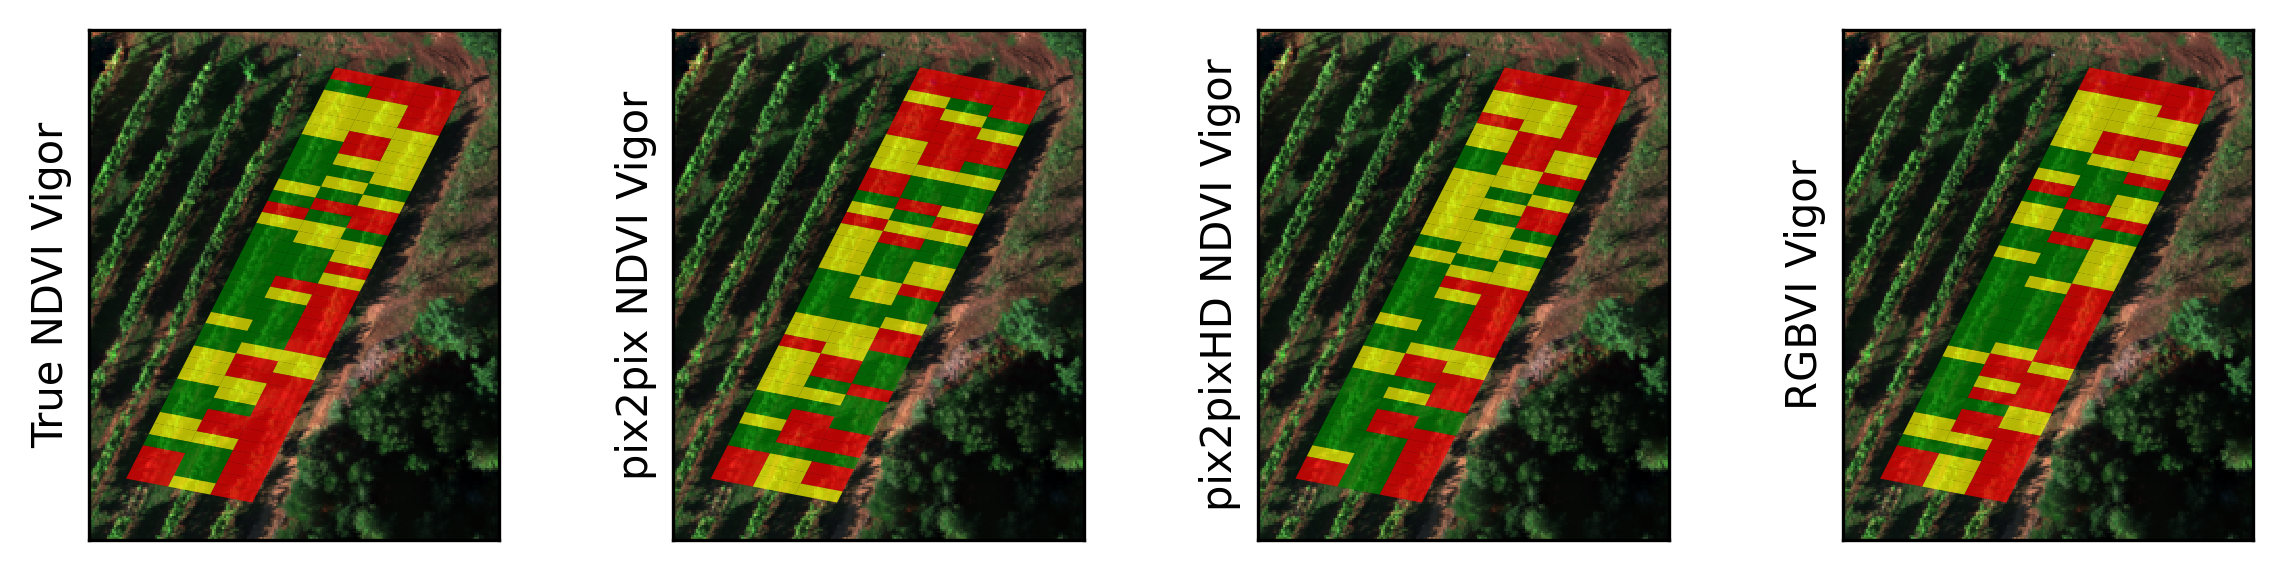

In [17]:
# plot thes 2x2 grid
d = {"low":"red", "medium":"yellow", "high":"green"}
ndvi_test_vigor["colour"] = ndvi_test_vigor["vigor_class"].map(d)
ndvi_p2p_vigor["colour"] = ndvi_p2p_vigor["vigor_class"].map(d)
ndvi_p2phd_vigor["colour"] = ndvi_p2phd_vigor["vigor_class"].map(d)
rgbvi_vigor["colour"] = rgbvi_vigor["vigor_class"].map(d)

fig,ax = plt.subplots(figsize=(8,2),nrows =1, ncols = 4,dpi=300)

bounds = ndvi_test_vigor.total_bounds
off= 3
rgb_down.plot.imshow(ax=ax[0],add_colorbar=False)
ndvi_test_vigor.plot(ax=ax[0], color=ndvi_test_vigor["colour"] , alpha=0.7)
ax[0].set_xlim()
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI Vigor")
ax[0].set_xlim(bounds[0]-off,bounds[2]+off)
ax[0].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[1],add_colorbar=False)
ndvi_p2p_vigor.plot(ax=ax[1], color=ndvi_p2p_vigor["colour"] , alpha=0.7)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix NDVI Vigor")
ax[1].set_xlim(bounds[0]-off,bounds[2]+off)
ax[1].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[2],add_colorbar=False)
ndvi_p2phd_vigor.plot(ax=ax[2], color=ndvi_p2phd_vigor["colour"], alpha=0.7 )
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD NDVI Vigor")
ax[2].set_xlim(bounds[0]-off,bounds[2]+off)
ax[2].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[3],add_colorbar=False)
rgbvi_vigor.plot(ax=ax[3], color=rgbvi_vigor["colour"], alpha=0.7 )
ax[3].set_title("")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xlabel("")
ax[3].set_ylabel("RGBVI Vigor")
ax[3].set_xlim(bounds[0]-off,bounds[2]+off)
ax[3].set_ylim(bounds[1]-off,bounds[3]+off)

plt.tight_layout()
plt.savefig("figures/btg2021_vigor_map.png")
plt.show()

In [19]:
# Accuracy matrix, F1 score, of low-medium-high 
test_p2p = pd.merge(left = ndvi_test_vigor, right= ndvi_p2p_vigor, on="plantID")[["plantID", "geometry_x", "vigor_class_x", "vigor_class_y"]]
test_p2phd = pd.merge(left = ndvi_test_vigor, right= ndvi_p2phd_vigor, on="plantID")[["plantID", "geometry_x", "vigor_class_x", "vigor_class_y"]]
test_rgbvi = pd.merge(left = ndvi_test_vigor, right= rgbvi_vigor, on="plantID")[["plantID", "geometry_x", "vigor_class_x", "vigor_class_y"]]

test_p2p = test_p2p.dropna(axis=0)
test_p2phd = test_p2phd.dropna(axis=0)
test_rgbvi = test_rgbvi.dropna(axis=0)

from sklearn.metrics import confusion_matrix, f1_score
clses = ["low", "medium", "high"]
conf_p2p = confusion_matrix(test_p2p["vigor_class_x"], test_p2p["vigor_class_y"], labels = clses)

conf_p2phd = confusion_matrix(test_p2phd["vigor_class_x"], test_p2phd["vigor_class_y"], labels = clses)

conf_rgbvi = confusion_matrix(test_rgbvi["vigor_class_x"], test_rgbvi["vigor_class_y"], labels = clses)


f1_p2p = f1_score(test_p2p["vigor_class_x"], test_p2p["vigor_class_y"], average='weighted')

f1_p2phd = f1_score(test_p2phd["vigor_class_x"], test_p2phd["vigor_class_y"], average='weighted')

f1_rgbvi =  f1_score(test_rgbvi["vigor_class_x"], test_rgbvi["vigor_class_y"], average='weighted')

In [20]:
print( "btg2021 f1 score p2p: ", "{:.3f}".format(f1_p2p), "matrix:")
print(pd.DataFrame(conf_p2p))
print( "btg2021 f1 score p2phd: ", "{:.3f}".format(f1_p2phd), "matrix:")
print(pd.DataFrame(conf_p2phd))

print( "btg2021 f1 score rgbvi: ", "{:.3f}".format(f1_rgbvi), "matrix:")
print(pd.DataFrame(conf_rgbvi))


btg2021 f1 score p2p:  0.523 matrix:
    0   1   2
0  25   6   8
1  11  15  10
2   3  15  18
btg2021 f1 score p2phd:  0.757 matrix:
    0   1   2
0  33   4   2
1   5  24   7
2   1   8  27
btg2021 f1 score rgbvi:  0.775 matrix:
    0   1   2
0  32   7   0
1   6  24   6
2   1   5  30


## Rubbish tests

In [62]:
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from functools import partial

In [64]:
# classify to values
d = {"low":1, "medium":2, "high":3, np.nan: 0}
ndvi_test_vigor["v"] = ndvi_test_vigor["vigor_class"].map(d)
ndvi_p2p_vigor["v"] = ndvi_p2p_vigor["vigor_class"].map(d)
ndvi_p2phd_vigor["v"] = ndvi_p2phd_vigor["vigor_class"].map(d)

In [67]:
# extract only centroids and keep geom + v columns
ndvi_test_vigor_p = ndvi_test_vigor.dropna().set_geometry(ndvi_test_vigor.geometry.centroid)[["geometry", "v"]]
ndvi_p2p_vigor_p = ndvi_p2p_vigor.dropna().set_geometry(ndvi_p2p_vigor.geometry.centroid)[["geometry", "v"]]
ndvi_p2phd_vigor_p = ndvi_p2phd_vigor.dropna().set_geometry(ndvi_p2phd_vigor.geometry.centroid)[["geometry", "v"]]

In [70]:
#generate high resolution rasters from the classification
ndvi_test_vigor_inter= make_geocube(vector_data = ndvi_test_vigor_p,
                    measurements = ["v"],
                    like = ndvi_test,
                    rasterize_function=partial(rasterize_points_griddata, method="linear")).v
ndvi_p2p_vigor_inter= make_geocube(vector_data = ndvi_p2p_vigor_p,
                    measurements = ["v"],
                    like = ndvi_test,
                    rasterize_function=partial(rasterize_points_griddata, method="linear")).v
ndvi_p2phd_vigor_inter= make_geocube(vector_data = ndvi_p2phd_vigor_p,
                    measurements = ["v"],
                    like = ndvi_test,
                    rasterize_function=partial(rasterize_points_griddata, method="linear")).v

In [72]:
#reduce RGB size for plotting
rgb = rxr.open_rasterio("../data/canyelles/orthos/rgb_230609.tif", chunks=True)
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = rgb.rio.width * upscale_factor
new_height = rgb.rio.height * upscale_factor


rgb_down =rgb.rio.reproject(
   "EPSG:32631",
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)
ndvi_test_vigor_inter_down =ndvi_test_vigor_inter.rio.reproject(
   "EPSG:32631",
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)
ndvi_p2p_vigor_inter_down =ndvi_p2p_vigor_inter.rio.reproject(
   "EPSG:32631",
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)
ndvi_p2phd_vigor_inter_down =ndvi_p2phd_vigor_inter.rio.reproject(
   "EPSG:32631",
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)

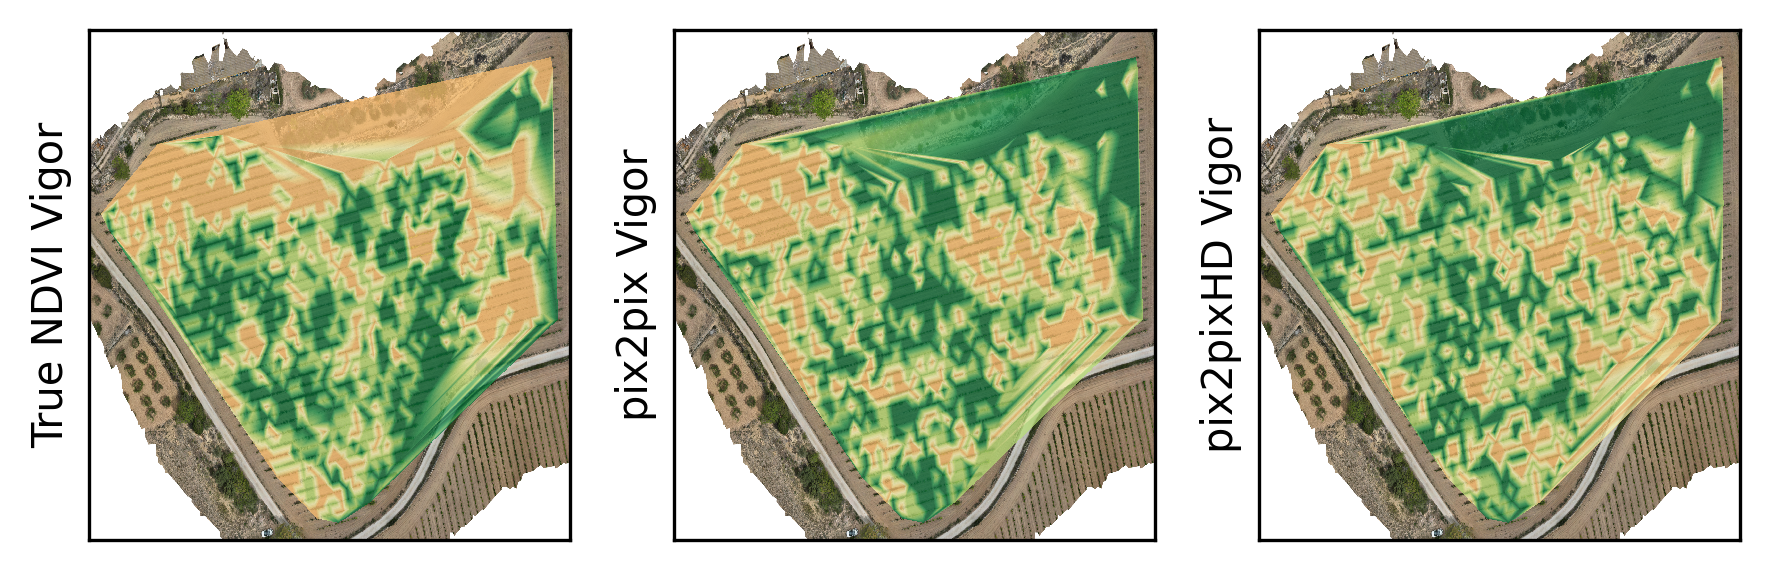

In [74]:
fig,ax = plt.subplots(figsize=(6,2),nrows =1, ncols = 3,dpi=300)

bounds = ndvi_test_vigor.total_bounds
off= 3
rgb_down.plot.imshow(ax=ax[0],add_colorbar=False)
ndvi_test_vigor_inter_down.plot(ax=ax[0], cmap = "RdYlGn", vmin = 0, vmax = 3 , alpha=0.7,add_colorbar=False)
ax[0].set_xlim()
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("True NDVI Vigor")
ax[0].set_xlim(bounds[0]-off,bounds[2]+off)
ax[0].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[1],add_colorbar=False)
ndvi_p2p_vigor_inter_down.plot(ax=ax[1], cmap = "RdYlGn", vmin = 0, vmax = 3 , alpha=0.7,add_colorbar=False)
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pix Vigor")
ax[1].set_xlim(bounds[0]-off,bounds[2]+off)
ax[1].set_ylim(bounds[1]-off,bounds[3]+off)

rgb_down.plot.imshow(ax=ax[2],add_colorbar=False)
ndvi_p2phd_vigor_inter_down.plot(ax=ax[2], cmap = "RdYlGn", vmin = 0, vmax = 3 , alpha=0.7,add_colorbar=False)
ax[2].set_title("")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel("")
ax[2].set_ylabel("pix2pixHD Vigor")
ax[2].set_xlim(bounds[0]-off,bounds[2]+off)
ax[2].set_ylim(bounds[1]-off,bounds[3]+off)

plt.tight_layout()
plt.savefig("figures/can2023_vigor_inter_map.png")
plt.show()